<a href="https://colab.research.google.com/github/galvaowesley/MachineLearning_Learning/blob/master/DeepLearning/TensorFlow/Intro_to_NLP_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Natural Language Processing with TensorFlow
===
Wesley Galvão 

Aug, 2020

This notebook is based on the videos serie of [TensorFlow channel](https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S)

# Preprocessing techniques

## Tokenization

The tokenization is a technique to represent the words in a way that a computer can process them. Thus, a tokenized sentence, or list of sentences, can be train a Neural Network later. 

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer

# List of sentences to tokenize
sentences = [
    'I love my mom',
    'I love my dad',
    'You love me!',
    'Do you think my dad is cool?'
]

# intializing a tokenizer that can index
# num_words is the maximum number words that can be kept 
# tokenizer will automatically help in choosing most frequent words
tokenizer = Tokenizer(num_words = 100)
# fitting the sentences to using created tokenizer object
tokenizer.fit_on_texts(sentences)
# the full list of words is available as the tokenizer's word index
word_index = tokenizer.word_index

# Print the indexed dictionary 
print("\nWord Index = ", word_index)



Word Index =  {'love': 1, 'my': 2, 'i': 3, 'dad': 4, 'you': 5, 'mom': 6, 'me': 7, 'do': 8, 'think': 9, 'is': 10, 'cool': 11}


## Sequecing

In this step we'll sequence the setences. Once the words are properly indexed and tokenized, the setences can be represented by a sequence of numbers ordered by their respective words. In other words, we'll create sequences of tokens that represent each sentence.

In [ ]:
# Create sequences of tokens that represent each sentence
sequences = tokenizer.texts_to_sequences(sentences)
print("\nWord Index = ", word_index)
print("\nSequences = ", sequences)


Word Index =  {'love': 1, 'my': 2, 'i': 3, 'dad': 4, 'you': 5, 'mom': 6, 'me': 7, 'do': 8, 'think': 9, 'is': 10, 'cool': 11}

Sequences =  [[3, 1, 2, 6], [3, 1, 2, 4], [5, 1, 7], [8, 5, 9, 2, 4, 10, 11]]


Note that each number of sequence corresponds to a token. For example, the sequence `[4, 2, 3, 7]` is related to the sentence `I love my mom`, because:
- `i`: 4
- `love` : 2
- `my` : 3
- `mom` : 7 

## Unseen words

Let's try to sequence a new list of sentences where there are words that the already fitted tokenizer is not familiarized with. What can happen?


In [ ]:
# New sentences with words that the tokenizer wasn't fit to
new_sentences = [
    'I love my girlfriend',
    'My dog is cool'
]

# Create sequences of tokens
new_seq = tokenizer.texts_to_sequences(new_sentences)
print("\nNew Sequence = ", new_seq)


New Sequence =  [[3, 1, 2], [2, 10, 11]]


Note that the sentence `I love my girlfriend` has 4 words, and the respective sequence` [3,1,2] `has only 3 numbers. This is because the tokenizer does not recognize the new word `girlfriend`. The same is true for the second sentence.

To work around this problem, we will use the parameter `oov_token = '<OOV>'` in the function `Tokenizer ()`. This generates an ** Out of Vocabulary ** token when an unrecognized token occurs in the vocabulary.

In [ ]:
# Apply tokenizer
tokenizer = Tokenizer(num_words = 100, oov_token = '<OOV>')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

# New sentences with words that the tokenizer wasn't fit to
new_sentences = [
    'I love my girlfriend',
    'My dog is cool'
]

# Create sequences of tokens representing each sentence
new_seq = tokenizer.texts_to_sequences(new_sentences)
print("\nWord Index = ", word_index)
print("\nNew Sequence = ", new_seq)


Word Index =  {'<OOV>': 1, 'love': 2, 'my': 3, 'i': 4, 'dad': 5, 'you': 6, 'mom': 7, 'me': 8, 'do': 9, 'think': 10, 'is': 11, 'cool': 12}

New Sequence =  [[4, 2, 3, 1], [3, 1, 11, 12]]


## Padding

So far, we have seen that the strings have different lengths. But what if we need to train a neural network, how to handle with sequences of different lengths?

For this, we will use the padding technique, that pads the sequence with zeros, if necessary. 

First, import `pad_sequence` method. 




In [ ]:
# Import pad_sequence method
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pass sequences to pad_sequence method 
# padded = pad_sequences(sequences, truncating = 'post', maxlen = 5)
padded = pad_sequences(sequences)

# Print the original and padded sequences
print("\nSequences = ", sequences)
print("\nPadded Sequences = ", padded)


Sequences =  [[3, 1, 2, 6], [3, 1, 2, 4], [5, 1, 7], [8, 5, 9, 2, 4, 10, 11]]

Padded Sequences =  [[ 0  0  0  3  1  2  6]
 [ 0  0  0  3  1  2  4]
 [ 0  0  0  0  5  1  7]
 [ 8  5  9  2  4 10 11]]




---

# Training a model to recognize sentiment in text




In this section we'll train a model to recognize if a sentence is sarcastic or not, based on the [dataset](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home) of [Rishabh Misra](https://rishabhmisra.github.io/).

The dataset is structured as json. The content has the following organization:

**Content**

Each record consists of three attributes:

- `is_sarcastic`: 1 if the record is sarcastic otherwise 0

- `headline`: the headline of the news article

- `article_link`: link to the original news article. Useful in collecting supplementary data


## Importing and loading dataset

In [88]:
# Import json library to handle json files
import json

import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Declare variables
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [77]:
# Download dataset to /temp directory
!wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json
  

--2020-08-09 23:02:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  13.4MB/s    in 0.4s    

2020-08-09 23:02:10 (13.4 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [78]:
# Open the dataset
with open("/tmp/sarcasm.json", 'r') as f:
  dataset = json.load(f)

sentences = []
labels = []

for item in dataset:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

# Print dataset head
dataset[0:5]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [79]:
# Covert to Dataframe
df = pd.DataFrame(dataset)
df.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Spliting dataset

Let's split dataset in two subsets. One to train the model and other to test the trained model. The train subset size is 20000.  

In [80]:
# Training subsets
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]
# Testing subsets
testing_sentences  = sentences[training_size:]
testing_labels = labels[training_size:]

## Preprocessing

In this section we will run the preprocessing techniques already seen. 

### Tokenization

In [82]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fitting the training sentences
tokenizer.fit_on_texts(training_sentences)
# Create a words dictionary
word_index = tokenizer.word_index


### Sequencing

In [86]:
# Create sequences of tokens that represent each sentence 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

### Padding

In [90]:
# Create padding sequences for training sentences 
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
# Create padding sequences for testing sentences 
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

## Training


In [91]:
# Convert the sets to array to get it to work with TensorFlow 2
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### Embedding

In [93]:
# Create a model
model = tf.keras.Sequential([
    # Embedding layer for NN                         
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Global Average pooling is similar to adding up vectors
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [95]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
epoch_num = 30
history = model.fit(training_padded, 
                    training_labels, 
                    epochs = epoch_num, 
                    validation_data = (testing_padded, testing_labels), verbose = 2)

### Evaluation

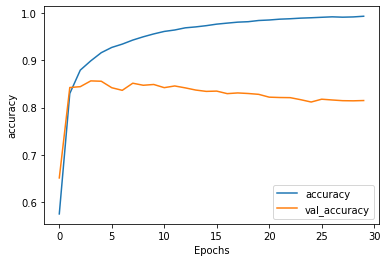

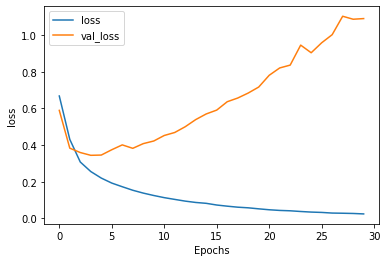

In [98]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Predicting sentences

In [120]:
# New sentences
new_sentences = [
    "Well, what a surprise, bitch", # sarcastic
    "Have a nice day, my dear", # not sarcastic
    "Nice perfume. How long did you marinate in it?", # sarcastic
    "granny starting to fear spider in the garden might be real", # sarcastic
    "game of thrones season finale showing this sunday night" # not sarcastic
]
# Sequencing
sequences = tokenizer.texts_to_sequences(new_sentences)
# Padding
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# Predicting
print(np.round(model.predict(padded),3))


[[0.787]
 [0.   ]
 [0.845]
 [0.113]
 [0.   ]]
